In [589]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
)

from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import (
    RadiusNeighborsClassifier,
    NeighborhoodComponentsAnalysis,
    KNeighborsClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

data = {
    "model": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "train_score": [],
    "test_score": [],
}
models = pd.DataFrame(columns=data)

pd.options.display.max_columns = None
titanic = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/train.csv"
)
test = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/test.csv"
)
ids = test["PassengerId"]

combine = [titanic, test]

    pclass : Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

    sibsp	# of siblings / spouses aboard the Titanic

    parch	# of parents / children aboard the Titanic

    ticket	Ticket number

    fare	Passenger fare

    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


# EDA


In [590]:
titanic.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [591]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [592]:
titanic.isna().sum() * 100 / len(titanic)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: Drop Cabin column, since it has  77 % missing data</b><br>
        <b>Insight: Drop name, PassengerId and Ticket columns, since this columns is not important</b><br>
    </span>    
</div>


31.871345029239766
68.12865497076024


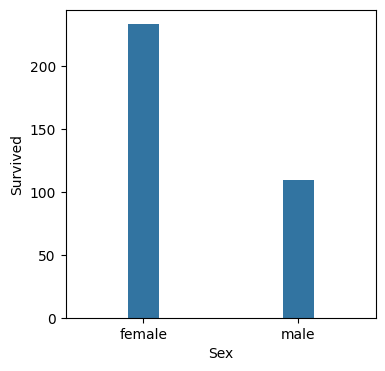

In [593]:
print(
    len(titanic[(titanic["Sex"] == "male") & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)
print(
    len(titanic[(titanic["Sex"] == "female") & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)

plt.figure(figsize=(4, 4))

data = titanic[titanic["Survived"] == 1]
sns.barplot(data=data, x="Sex", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: as a prediction, females have a much higher chance of survival than males</b><br>
    </span>    
</div>


39.76608187134503
25.43859649122807
34.7953216374269


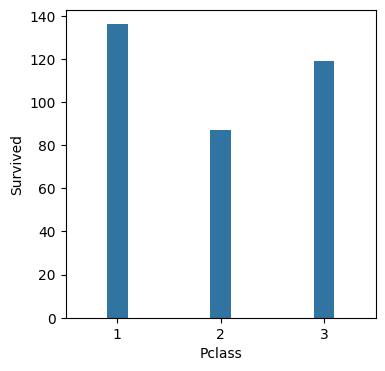

In [594]:
print(
    len(titanic[(titanic["Pclass"] == 1) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)
print(
    len(titanic[(titanic["Pclass"] == 2) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)

print(
    len(titanic[(titanic["Pclass"] == 3) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)


plt.figure(figsize=(4, 4))
data = titanic[titanic["Survived"] == 1]
sns.barplot(data=data, x="Pclass", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: the class is not effected sinece people in 3rd class and Survived more the  in 2rd class</b><br>
    </span>    
</div>


0  : 61.40350877192982
1  : 32.748538011695906
2  : 3.801169590643275
3  : 1.1695906432748537
4  : 0.8771929824561403


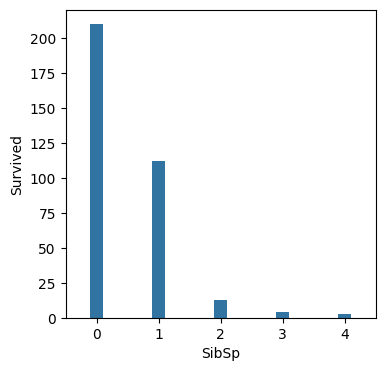

In [595]:
data = titanic[titanic["Survived"] == 1]

arr = data["SibSp"].unique()
arr = list(arr)
arr.sort()
for val in arr:
    print(val, " :", len(data[(data["SibSp"] == val)]) * 100 / len(data))

plt.figure(figsize=(4, 4))
sns.barplot(data=data, x="SibSp", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: as a prediction, when you have less number of siblings or spouses, you will have a much higher chance of survival</b><br>
    </span>    
</div>


In [596]:
data = titanic[titanic["Survived"] == 1]

sns.lineplot(data=data, x="Age", y="Survived", estimator="sum")

# Cleaning


In [ ]:
titanic = titanic.drop(["Ticket", "Cabin"], axis=1)
test = test.drop(["Ticket", "Cabin"], axis=1)

combine = [titanic, test]

for dataset in combine:
    dataset["Title"] = dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False)

### Missing values and edidting columns


In [ ]:
mapper = {"female": 0, "male": 1}

for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map(mapper)
    dataset["Age"] = dataset["Age"].fillna(int(dataset["Age"].mean()))
    dataset["Embarked"] = dataset["Embarked"].fillna(dataset["Embarked"].mode()[0])
    dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].mean())

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,S,Mr


### Constructing new columns


In [ ]:
mapper = {"Mr": 1, "Mrs": 2, "Miss": 3, "Master": 4, "Rare": 5}


def ubdate_age(age):
    if age <= 16:
        return 0
    if age <= 32:
        return 1
    if age <= 48:
        return 2
    if age <= 65:
        return 3
    if age <= 85:
        return 4


def ubdate_fare(fare):
    if fare <= 7.9:
        return 0
    if fare <= 14.5:
        return 1
    if fare <= 31:
        return 2
    return 3


def ubdate_Embarked(Embarked):
    if Embarked == "C":
        return 0
    if Embarked == "Q":
        return 1
    if Embarked == "S":
        return 2


def alone_or_not(family_sz):
    if family_sz == 1:
        return 1
    return 0


for dataset in combine:
    dataset["Title"] = dataset["Title"].replace(
        [
            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",
            "Jonkheer",
            "Dona",
        ],
        "Rare",
    )

    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")
    dataset["Title"] = dataset["Title"].map(mapper)

    dataset["Age"] = dataset["Age"].apply(ubdate_age)

    dataset["Fare"] = dataset["Age"].apply(ubdate_fare)

    dataset["Family size"] = dataset["SibSp"] + dataset["Parch"] + 1

    dataset["Is Alone"] = dataset["Family size"].apply(alone_or_not)

    dataset["Embarked"] = dataset["Embarked"].apply(ubdate_Embarked)

    dataset["Age*calss"] = dataset["Age"] * dataset["Pclass"]

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family size,Is Alone,Age*calss
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,0,2,1,2,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,0,0,2,2,0,2
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,0,2,3,1,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,0,2,2,2,0,2
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,0,2,1,1,1,6


In [ ]:
titanic = titanic.drop(["Name", "PassengerId", "Parch", "SibSp", "Family size"], axis=1)
test = test.drop(["Name", "Parch", "SibSp", "Family size"], axis=1)
combine = [titanic, test]

In [ ]:
titanic.isna().sum(), test.isna().sum()

(Survived     0
 Pclass       0
 Sex          0
 Age          0
 Fare         0
 Embarked     0
 Title        0
 Is Alone     0
 Age*calss    0
 dtype: int64,
 PassengerId    0
 Pclass         0
 Sex            0
 Age            0
 Fare           0
 Embarked       0
 Title          0
 Is Alone       0
 Age*calss      0
 dtype: int64)

In [ ]:
titanic.head()
SVm_ploting = titanic

# Spliting data


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    titanic.drop(columns="Survived", axis="columns"),
    titanic["Survived"],
    random_state=34,
    test_size=0.3,
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(712, 8)
(712,)
(179, 8)
(179,)


# Models

- Logistic Regression
- k-Nearest Neighbors
- R-Nearest Neighbors
- Decision Tree Classifier
- Random Forest Classifier


## 1) LogisticRegression


In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X=x_train, y=y_train)

train_score = log_reg.score(x_train, y_train)
test_score = log_reg.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.7893258426966292
train score =  0.7932960893854749


In [ ]:
log_reg_prediction = log_reg.predict(x_test)
MAE = mean_absolute_error(y_pred=log_reg_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=log_reg_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.20670391061452514, 0.20670391061452514, 0.454647017602145)

In [ ]:
data = {
    "model": "LogisticRegression",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.206704,0.206704,0.454647,0.789326,0.793296


In [ ]:
y_p = cross_val_predict(log_reg, x_test, y_test, cv=20)

accuracy_score(y_test, y_p)

0.7932960893854749

## 2) k-Nearest Neighbors


In [ ]:
num_neighbors = int(np.sqrt(len(x_train)))

neighbors = [num_neighbors]
for i in range(9):
    neighbors.append(num_neighbors + i + 1)
for i in range(9):
    neighbors.append(num_neighbors - (i + 1))

KNC_models = []
Cross_valdation = []

for k in neighbors:
    KNC = KNeighborsClassifier(n_neighbors=k, algorithm="ball_tree")
    KNC.fit(X=x_train, y=y_train)
    valdation = cross_val_score(KNC, X=x_train, y=y_train, cv=4)
    KNC_models.append(KNC)
    Cross_valdation.append([k, np.mean(valdation), np.std(valdation)])

train_score = [KNC_.score(x_train, y_train) for KNC_ in KNC_models]
test_score = [KNC_.score(x_test, y_test) for KNC_ in KNC_models]


Cross_valdation_results = pd.DataFrame(
    Cross_valdation, columns=["K-neighbors", "mean_acc", "std"]
)

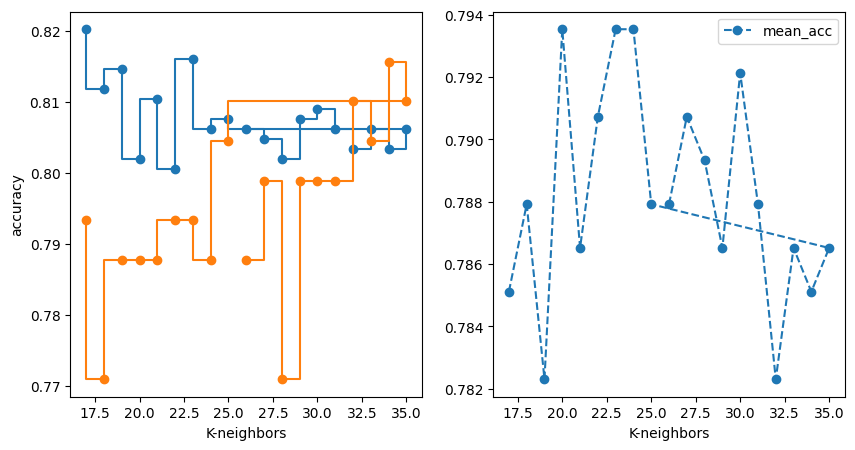

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("K-neighbors")
ax[0].set_ylabel("accuracy")
ax[0].plot(neighbors, train_score, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(neighbors, test_score, marker="o", label="test", drawstyle="steps-post")

Cross_valdation_results.plot(
    x="K-neighbors", y="mean_acc", linestyle="--", marker="o", ax=ax[1]
)

plt.legend()
plt.show()

### By the cross val score, when the data set changed the model becomes unstabel, more formally this model is not good


### BEST K is 26, with about .80 score for traing and 0.84 score for testing


In [ ]:
KNC = KNeighborsClassifier(n_neighbors=26, algorithm="ball_tree")
KNC.fit(X=x_train, y=y_train)
train_score = KNC.score(x_train, y_train)
test_score = KNC.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.8061797752808989
train score =  0.7877094972067039


In [ ]:
KNC_prediction = KNC.predict(x_test)
MAE = mean_absolute_error(y_pred=KNC_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=KNC_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.2122905027932961, 0.2122905027932961, 0.46074993520704494)

In [ ]:
data = {
    "model": "KNeighborsClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.206704,0.206704,0.454647,0.789326,0.793296
1,KNeighborsClassifier,0.212291,0.212291,0.460750,0.806180,0.787709


## 3) R-Nearest Neighbors


In [ ]:
R = 50

Raduisies = [R]
for i in range(20):
    Raduisies.append(R + i + 0.5)

for i in range(20):
    Raduisies.append(R - (i + 0.5))

RNC_models = []
Cross_valdation = []

for r in Raduisies:
    RNC = RadiusNeighborsClassifier(radius=r, algorithm="ball_tree")
    RNC.fit(X=x_train, y=y_train)
    valdation = cross_val_score(RNC, X=x_train, y=y_train, cv=4)
    RNC_models.append(RNC)
    Cross_valdation.append([r, np.mean(valdation), np.std(valdation)])

train_score = [RNC_.score(x_train, y_train) for RNC_ in RNC_models]
test_score = [RNC_.score(x_test, y_test) for RNC_ in RNC_models]


Cross_valdation_results = pd.DataFrame(
    Cross_valdation, columns=["R-neighbors", "mean_acc", "std"]
)

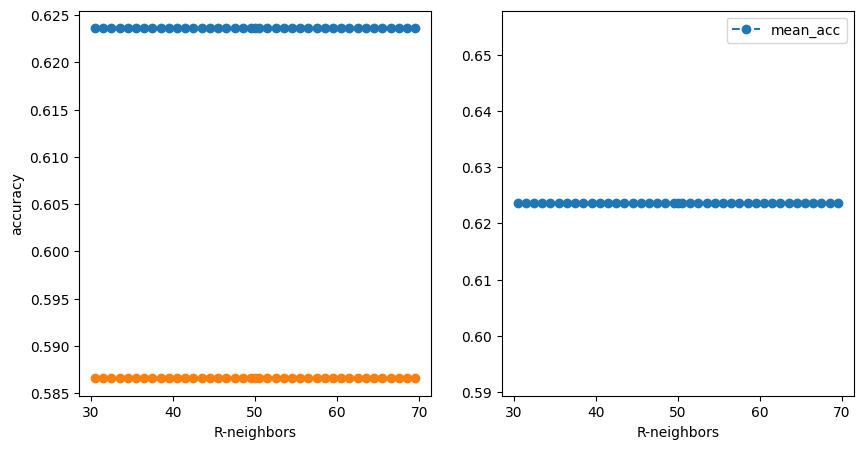

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("R-neighbors")
ax[0].set_ylabel("accuracy")
ax[0].plot(Raduisies, train_score, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(Raduisies, test_score, marker="o", label="test", drawstyle="steps-post")

Cross_valdation_results.plot(
    x="R-neighbors", y="mean_acc", linestyle="--", marker="o", ax=ax[1]
)

plt.legend()
plt.show()

### I think it is a bad decision to choose RadiusNeighborsClassifier model 🤣🤣🤣


### How ever, i will choose 40.5 as a raduis


In [ ]:
RNC = RadiusNeighborsClassifier(radius=40.5, algorithm="ball_tree")
RNC.fit(X=x_train, y=y_train)
train_score = RNC.score(x_train, y_train)
test_score = RNC.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.6235955056179775
train score =  0.5865921787709497


In [ ]:
RNC_prediction = RNC.predict(x_test)
MAE = mean_absolute_error(y_pred=RNC_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RNC_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.4134078212290503, 0.4134078212290503, 0.6429679783854327)

In [ ]:
data = {
    "model": "RadiusNeighborsClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.206704,0.206704,0.454647,0.789326,0.793296
1,KNeighborsClassifier,0.212291,0.212291,0.460750,0.806180,0.787709
2,RadiusNeighborsClassifier,0.413408,0.413408,0.642968,0.623596,0.586592


## 4) Decision Tree Classifier


In [ ]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

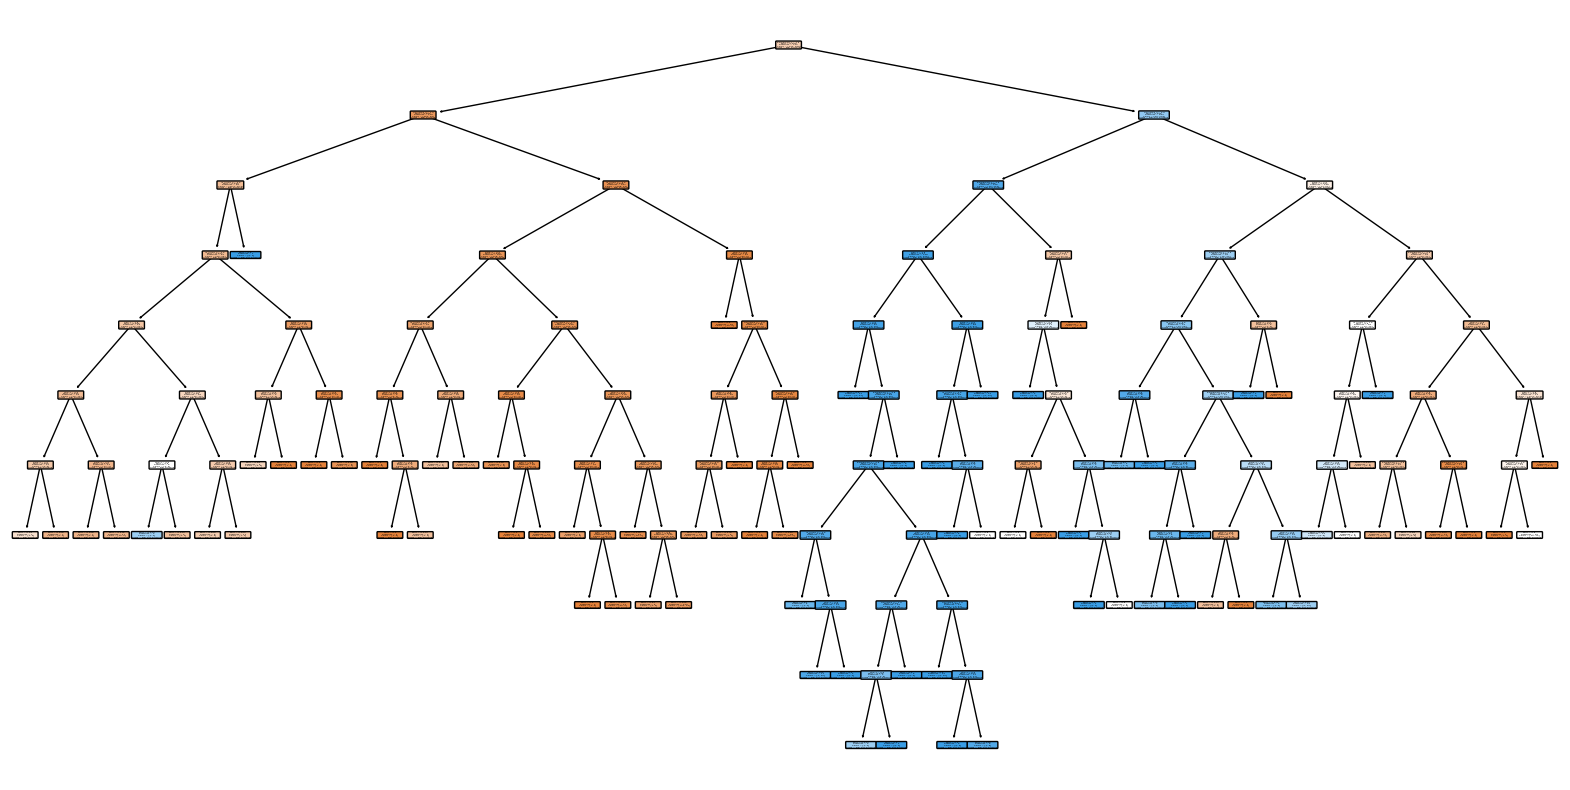

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    DTC,
    class_names=["will Survive", "will not Survive"],
    filled=True,
    rounded=True,
    feature_names=titanic.columns,
)
plt.show()

### I think this tree over fit the model


In [ ]:
print(DTC.score(x_train, y_train))
print(DTC.score(x_test, y_test))

0.8455056179775281
0.8044692737430168


### as I expected, there is an overfit probelm, let's fix it by pruning the tree


In [ ]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]
DTC_models = []

Cross_valdation = []

for alpha in alphas:
    DTC = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    DTC.fit(x_train, y_train)
    score = cross_val_score(DTC, x_train, y_train, cv=5)
    Cross_valdation.append([alpha, np.mean(score), np.std(score)])
    DTC_models.append(DTC)


train_score = [DTC_.score(x_train, y_train) for DTC_ in DTC_models]
test_score = [DTC_.score(x_test, y_test) for DTC_ in DTC_models]

alpha_results = pd.DataFrame(Cross_valdation, columns=["alpha", "mean_acc", "std"])

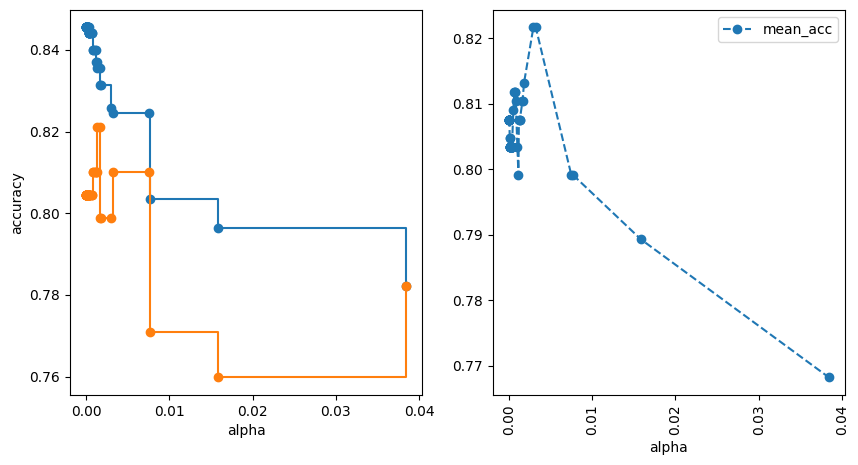

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")

ax[0].plot(alphas, train_score, marker="o", label="train", drawstyle="steps-post")
plt.xticks(rotation=90)

ax[0].plot(alphas, test_score, marker="o", label="test", drawstyle="steps-post")
plt.xticks(rotation=90)

alpha_results.plot(x="alpha", y="mean_acc", linestyle="--", marker="o", ax=ax[1])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
alpha = alpha_results[
    (alpha_results["alpha"] <= 0.005) & (alpha_results["alpha"] > 0.001)
]["alpha"]

alpha

42    0.001034
43    0.001163
44    0.001214
45    0.001310
46    0.001326
47    0.001644
48    0.001653
49    0.001831
50    0.002953
51    0.003245
Name: alpha, dtype: float64

In [ ]:
DTC_pruned = DecisionTreeClassifier(ccp_alpha=0.001453, random_state=42)
DTC_pruned.fit(x_train, y_train)
train_score = DTC_pruned.score(x_train, y_train)
test_score = DTC_pruned.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.8356741573033708
test score =  0.8212290502793296


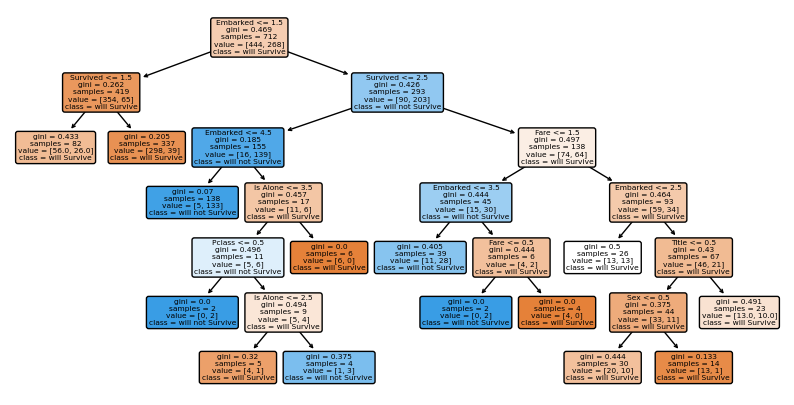

In [ ]:
plt.figure(figsize=(10, 5))
plot_tree(
    DTC_pruned,
    class_names=["will Survive", "will not Survive"],
    filled=True,
    rounded=True,
    feature_names=titanic.columns,
)
plt.show()

### Great work


In [ ]:
DTC_pruned_prediction = DTC_pruned.predict(x_test)
MAE = mean_absolute_error(y_pred=DTC_pruned_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=DTC_pruned_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.1787709497206704, 0.1787709497206704, 0.422813138065352)

In [ ]:
data = {
    "model": "DecisionTreeClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.206704,0.206704,0.454647,0.789326,0.793296
1,KNeighborsClassifier,0.212291,0.212291,0.460750,0.806180,0.787709
2,RadiusNeighborsClassifier,0.413408,0.413408,0.642968,0.623596,0.586592
3,DecisionTreeClassifier,0.178771,0.178771,0.422813,0.835674,0.821229


## 5) Random Forest


In [ ]:
RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=0.002408)
RF.fit(X=x_train, y=y_train)
RF.score(X=x_train, y=y_train), RF.score(X=x_test, y=y_test)

(0.8384831460674157, 0.8100558659217877)

In [ ]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]

RF_models = []

Cross_valdation = []

for alpha in alphas:
    RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=alpha)
    RF.fit(x_train, y_train)
    score = cross_val_score(RF, x_train, y_train, cv=5)
    Cross_valdation.append([alpha, np.mean(score), np.std(score)])
    RF_models.append(RF)


train_score = [RF_.score(x_train, y_train) for RF_ in RF_models]
test_score = [RF_.score(x_test, y_test) for RF_ in RF_models]

alpha_results = pd.DataFrame(Cross_valdation, columns=["alpha", "mean_acc", "std"])

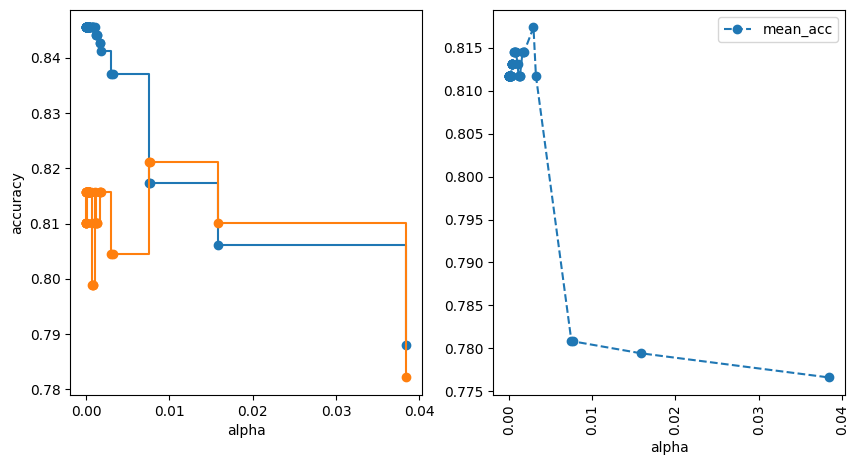

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")

ax[0].plot(alphas, train_score, marker="o", label="train", drawstyle="steps-post")
plt.xticks(rotation=90)

ax[0].plot(alphas, test_score, marker="o", label="test", drawstyle="steps-post")
plt.xticks(rotation=90)

alpha_results.plot(x="alpha", y="mean_acc", linestyle="--", marker="o", ax=ax[1])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
alpha = alpha_results[
    (alpha_results["alpha"] <= 0.005) & (alpha_results["alpha"] >= 0.002)
]["alpha"]

alpha

50    0.002953
51    0.003245
Name: alpha, dtype: float64

In [ ]:
RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=0.003673)
RF.fit(X=x_train, y=y_train)
train_score = RF.score(x_train, y_train)
test_score = RF.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.8370786516853933
test score =  0.8044692737430168


In [ ]:
RF_prediction = RF.predict(x_test)
MAE = mean_absolute_error(y_pred=RF_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RF_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.19553072625698323, 0.19553072625698323, 0.4421885641408914)

In [ ]:
data = {
    "model": "RandomForestClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.206704,0.206704,0.454647,0.789326,0.793296
1,KNeighborsClassifier,0.212291,0.212291,0.460750,0.806180,0.787709
2,RadiusNeighborsClassifier,0.413408,0.413408,0.642968,0.623596,0.586592
3,DecisionTreeClassifier,0.178771,0.178771,0.422813,0.835674,0.821229
4,RandomForestClassifier,0.195531,0.195531,0.442189,0.837079,0.804469


## 5) Support vector machines


In [ ]:
SVm_ploting

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Is Alone,Age*calss
0,0,3,1,1,0,2,1,0,3
1,1,1,0,2,0,0,2,0,2
2,1,3,0,1,0,2,3,1,3
3,1,1,0,2,0,2,2,0,2
4,0,3,1,2,0,2,1,1,6
...,...,...,...,...,...,...,...,...,...
886,0,2,1,1,0,2,5,1,2
887,1,1,0,1,0,2,3,1,1
888,0,3,0,1,0,2,3,0,3
889,1,1,1,1,0,0,1,1,1


In [ ]:
param_grid = {
    "C": [0, 0.5, 1, 2, 5, 10],
    "gamma": ["sacle", 1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "ploy"],
    "degree": [1, 2, 4],
}

opitmized_para = GridSearchCV(
    SVC(random_state=42), param_grid=param_grid, cv=5, scoring="accuracy"
)
opitmized_para.fit(x_train, y_train)

/home/ahmed/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
870 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ahmed/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ahmed/.local/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/home/ahmed/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/ahmed/.local/

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0, 0.5, 1, 2, 5, 10], 'degree': [1, 2, 4],
                         'gamma': ['sacle', 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'ploy']},
             scoring='accuracy')

In [ ]:
opitmized_para.best_params_

{'C': 5, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
opitmized_svm = SVC(C=5, gamma=1, kernel="rbf", degree=1)
opitmized_svm.fit(X=x_train, y=y_train)
train_score = opitmized_svm.score(x_train, y_train)
test_score = opitmized_svm.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.8455056179775281
test score =  0.8044692737430168


In [ ]:
svc_prediction = opitmized_svm.predict(x_test)
MAE = mean_absolute_error(y_pred=svc_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=svc_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.19553072625698323, 0.19553072625698323, 0.4421885641408914)

In [ ]:
data = {
    "model": "SVC",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.206704,0.206704,0.454647,0.789326,0.793296
1,KNeighborsClassifier,0.212291,0.212291,0.460750,0.806180,0.787709
2,RadiusNeighborsClassifier,0.413408,0.413408,0.642968,0.623596,0.586592
3,DecisionTreeClassifier,0.178771,0.178771,0.422813,0.835674,0.821229
4,RandomForestClassifier,0.195531,0.195531,0.442189,0.837079,0.804469
5,SVC,0.189944,0.189944,0.435826,0.832865,0.810056


# Votting


In [ ]:
estimators = [
    ("SVC", SVC(C=10, gamma=0.1, kernel="rbf", degree=1, probability=True)),
    ("DTC_purned", DecisionTreeClassifier(ccp_alpha=0.001713, random_state=42)),
    (
        "RF",
        RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=00.002573),
    ),
]

wghts = [
    opitmized_svm.score(x_train, y_train),
    DTC.score(x_train, y_train),
    RF.score(x_train, y_train),
]

vot = VotingClassifier(estimators=estimators, voting="soft", weights=wghts)
vot

VotingClassifier(estimators=[('SVC',
                              SVC(C=10, degree=1, gamma=0.1, probability=True)),
                             ('DTC_purned',
                              DecisionTreeClassifier(ccp_alpha=0.001713,
                                                     random_state=42)),
                             ('RF',
                              RandomForestClassifier(ccp_alpha=0.002573,
                                                     n_estimators=20,
                                                     random_state=42))],
                 voting='soft',
                 weights=[0.8328651685393258, 0.7823033707865169,
                          0.8370786516853933])

In [ ]:
vot.fit(x_train, y_train)
train_score = vot.score(x_train, y_train)
test_score = vot.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.8384831460674157
test score =  0.8212290502793296


In [ ]:
vot_prediction = vot.predict(x_test)
MAE = mean_absolute_error(y_pred=RF_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RF_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.19553072625698323, 0.19553072625698323, 0.4421885641408914)

In [ ]:
data = {
    "model": "VotingClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.206704,0.206704,0.454647,0.789326,0.793296
1,KNeighborsClassifier,0.212291,0.212291,0.460750,0.806180,0.787709
2,RadiusNeighborsClassifier,0.413408,0.413408,0.642968,0.623596,0.586592
3,DecisionTreeClassifier,0.178771,0.178771,0.422813,0.835674,0.821229
4,RandomForestClassifier,0.195531,0.195531,0.442189,0.837079,0.804469
5,SVC,0.189944,0.189944,0.435826,0.832865,0.810056
6,VotingClassifier,0.195531,0.195531,0.442189,0.838483,0.821229


In [ ]:
models.sort_values(by=["test_score"], ascending=[False])

,model,MAE,MSE,RMSE,train_score,test_score
3,DecisionTreeClassifier,0.178771,0.178771,0.422813,0.835674,0.821229
6,VotingClassifier,0.195531,0.195531,0.442189,0.838483,0.821229
5,SVC,0.189944,0.189944,0.435826,0.832865,0.810056
4,RandomForestClassifier,0.195531,0.195531,0.442189,0.837079,0.804469
0,LogisticRegression,0.206704,0.206704,0.454647,0.789326,0.793296
1,KNeighborsClassifier,0.212291,0.212291,0.460750,0.806180,0.787709
2,RadiusNeighborsClassifier,0.413408,0.413408,0.642968,0.623596,0.586592


In [ ]:
predictions = opitmized_svm.predict(test.drop("PassengerId", axis="columns"))

submmition = pd.DataFrame({"PassengerId": ids, "Survived": predictions})
submmition.to_csv(
    "/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/submission.csv",
    index=False,
)

# The END
